# MLJ Example

The closest equivalent I've seen to `scikit-learn` for Julia is `MLJ`. `MLJ` provides a unified API wrapper around a variety of ML libraries available in Julia. 

Here we'll walk through basic `MLJ` examples with some side notes on the quirks of this library.

1. Selecting and loading a *'model'* in `MLJ`, where 'model' is a container of hyperparameters
2. Create a *'machine'* which binds the *model* to *data* and checks data types
3. `fit!` to fit the data
4. `evaluate!` or `evaluate` the model performance using a *resampling* strategy against metrics (*measure*)

In [167]:
# import Pkg; Pkg.add("MLJ"); Pkg.add("MLJDecisionTreeInterface")
using MLJ, DataFramesMeta, Plots

In [168]:
# MLJ has some datasets builtin
iris = load_iris();
typeof(iris)

NamedTuple{(:sepal_length, :sepal_width, :petal_length, :petal_width, :target), Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, CategoricalArrays.CategoricalVector{String, UInt32, String, CategoricalArrays.CategoricalValue{String, UInt32}, Union{}}}}

In [169]:
# but it comes as a special NamedTuple with 'scitypes' inside of it, so let's make it into a dataframe
iris = DataFrame(iris)
# and we can `pretty` print the dataframe
first(iris,3) |> pretty

┌──────────────┬─────────────┬──────────────┬─────────────┬──────────────────────────────────┐
│ sepal_length │ sepal_width │ petal_length │ petal_width │ target                           │
│ Float64      │ Float64     │ Float64      │ Float64     │ CategoricalValue{String, UInt32} │
│ Continuous   │ Continuous  │ Continuous   │ Continuous  │ Multiclass{3}                    │
├──────────────┼─────────────┼──────────────┼─────────────┼──────────────────────────────────┤
│ 5.1          │ 3.5         │ 1.4          │ 0.2         │ setosa                           │
│ 4.9          │ 3.0         │ 1.4          │ 0.2         │ setosa                           │
│ 4.7          │ 3.2         │ 1.3          │ 0.2         │ setosa                           │
└──────────────┴─────────────┴──────────────┴─────────────┴──────────────────────────────────┘


In [170]:
# There's a univariate time series one here too
sunspots = MLJ.load_sunspots() |> DataFrame;

Let's run an initial model on this DataFrame. Since `MLJ` is a wrapper on top of a bunch of other libraries, we need a way to explore the catalog of models that are available and load specific models so that we can put them to work. 

* See the [Model Search](https://alan-turing-institute.github.io/MLJ.jl/dev/model_search/) section in the `MLJ` docs for more details
* `models("KMeans")`: Lists models in the catalog that match the name "KMeans"
* `info("KMeans", pkg="Clustering")`: Show the parameters for the "KMeans" model from the "Clustering" package
* `doc("KMeans", pkg="Clustering")`: Show the docs for the "KMeans" model from the "Clustering" package

In [171]:
# Show an example as a dataframe
example = info("KMeans", pkg="Clustering") |> pairs |> collect |> DataFrame
example[1,["name", "package_name", "human_name", "hyperparameters", "is_pure_julia"]] |> DataFrame |> pretty

┌─────────┬──────────────┬───────────────────┬──────────────────────────────────┬───────────────┐
│ name    │ package_name │ human_name        │ hyperparameters                  │ is_pure_julia │
│ String  │ String       │ String            │ Tuple{Symbol, Symbol, Symbol}    │ Bool          │
│ Textual │ Textual      │ Textual           │ Tuple{Unknown, Unknown, Unknown} │ Count         │
├─────────┼──────────────┼───────────────────┼──────────────────────────────────┼───────────────┤
│ KMeans  │ Clustering   │ K-means clusterer │ (:k, :metric, :init)             │ true          │
└─────────┴──────────────┴───────────────────┴──────────────────────────────────┴───────────────┘


Now here's an example of running the KMeans model with $k=3$ to split the `iris` data into 3 clusters:

In [172]:
KMeans = @load KMeans pkg=Clustering verbosity=0
# Split the dataframe into y and X, where y is the column `target`  and X is everything else
y, X = unpack(iris, ==(:target))
model = KMeans(k=3)
mach = machine(model, X) |> fit!

yhat = predict(mach, X)

# Check cluster assignments
compare = zip(yhat, y) |> collect
compare[1:8] # clusters align with classes

┌ Info: Training machine(KMeans(k = 3, …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492


8-element Vector{Tuple{CategoricalArrays.CategoricalValue{Int64, UInt32}, CategoricalArrays.CategoricalValue{String, UInt32}}}:
 (1, "setosa")
 (3, "setosa")
 (3, "setosa")
 (3, "setosa")
 (1, "setosa")
 (1, "setosa")
 (3, "setosa")
 (1, "setosa")

Let's review what happened in the cell above:

* `@load`: loads the specified model from the catalog and brings it in to the environment
* `unpack(iris, ==(:target))`: horizontally split the `iris` data into X and y, where y are all columns called "target" (here we use the symbol `:target`)
* `KMeans(k=3)`: Instantiate the KMeans model (from the `@load` on line 1) and set $k=3$
*  `machine(model, X) |> fit!`: We create a 'machine' that combines a model with training data and then `fit!` trains the model on the data
   *  The pipe operator `|>` is similar to method chaining in python or `dplyr`'s pipe in R
*  `predict(mach, X)`: Provides the predicted cluster assignments for each row of $X$

This also created a fitted machine that we can call things like `fitted_params`, which in the case of `KMeans` just has a single parameter `centers` and each row corresponds to a column from the `iris` training data (sepal length, sepal width, etc)

In [173]:
fitted_params(mach).centers

4×3 Matrix{Float64}:
 5.21667  6.31458  4.74167
 3.64     2.89583  2.95417
 1.47333  4.97396  1.75417
 0.28     1.70313  0.329167

and we can generate a report on the fitted machine with `report` to get some of the key outputs. This includes:

* `assignments`: cluster assignments
* `cluster_labels`: cluster labels

In [140]:
report(mach)

(assignments = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  3, 3, 1, 3, 3, 3, 1, 3, 3, 1],
 cluster_labels = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 2, 3],)

# A more involved example with the `boston` dataset

Let's build on the clustering example with an example from supervised learning. Below we'll take the popular boston housing dataset so we can show how to use `MLJ` to do things like a train/test split and evaluating against accuracy metrics.

In [141]:
# Load in boston housing market data
boston = load_boston() |> DataFrame
first(boston,3)

Row,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [279]:
# Train Test Split with `partition`
train, test = partition(boston, 0.8, rng=42);

# As before, unpack to horizontally split into y and X
y_train, X_train = unpack(train, ==(:MedV))
y_test, X_test = unpack(test, ==(:MedV));

# Load in our model and instantiate it
Tree = @load RandomForestRegressor pkg=DecisionTree verbosity=0;
tree = Tree()

RandomForestRegressor(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 10, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

Next we build our machine with the training data, and fit it:

In [280]:
mach = machine(tree, X_train, y_train) |> fit!

┌ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492


trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @108 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @321 ⏎ AbstractVector{Continuous}


### Model Evaluation

Now we want to check our accuracy in terms of RMSE - instead of doing the old `predict` one time, let's use `evaluate` to see how this model performs with 5-fold cross validation:

In [281]:
results = evaluate!(mach, resampling=CV(nfolds=5, rng=42), measure=rms, operation=predict)

Evaluating over 5 folds:  40%[==========>              ]  ETA: 0:00:00

Evaluating over 5 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────┬───────────┬─────────────┬─────────┬──────────────────
│ measure                │ operation │ measurement │ 1.96*SE │ per_fold        ⋯
├────────────────────────┼───────────┼─────────────┼─────────┼──────────────────
│ RootMeanSquaredError() │ predict   │ 3.52        │ 0.4     │ [4.15, 3.16, 3. ⋯
└────────────────────────┴───────────┴─────────────┴─────────┴──────────────────
                                                                1 column omitted


In [282]:
report(mach)

(features = [:Crim, :Zn, :Indus, :Chas, :NOx, :Rm, :Age, :Dis, :Rad, :Tax, :PTRatio, :Black, :LStat],)

This is really cool - it lets you specify the evaluation strategy quite nicely. 

* See [measure list](https://alan-turing-institute.github.io/MLJ.jl/stable/performance_measures/#List-of-measures) for a list of possible performance measures

Next, we check RMSE against the test set with `predict`:

In [285]:
y_pred = predict(mach, X_test)
# Check RMSE accuracy:
rms(y_pred, y_test)

4.423139873057788

## Dealing with `scitype`s

The above example works as a quickstart but as soon as we jump into linear regression, we run into an issue. Let's say I load in Linear Regression:

In [146]:
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels verbosity=0
ols = LinearRegressor()

LinearRegressor(
  fit_intercept = true, 
  solver = nothing)

Now, if we run `ols_mach = machine(ols, X_train, y_train) |> fit!` again, we'll run into an error:

```julia
ols_mach = machine(ols, X_train, y_train) |> fit!

>┌ Warning: The number and/or types of data arguments do not match what the specified model
>│ supports. Suppress this type check by specifying `scitype_check_level=0`.
..
>│ In general, data in `machine(model, data...)` is expected to satisfy
>│ 
>│     scitype(data) <: MLJ.fit_data_scitype(model)
>│ 
>│ In the present case:
>│ 
>│ scitype(data) = Tuple{Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}, AbstractVector{Continuous}}
>│ 
>│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{Continuous}}
```

The important part of this error is right after "In the present case" and it's the stuff in the `{}` brackets which specify the `scitype`.

* `scitype(data) = ...` is telling us that we have `Continuous` and `Count` data
* `fit_data_scitype(model) = ...` tells us that this model needs `Continuous` data only.

In other words, the model needs `Continuous` data but there's `Count` data in there right now. We need to use `schema` to figure out where the problem is and `coerce` it into the right data type.

### Check data `scitype` with `schema`

You can inspect the data `scitype` with the `schema` command:


In [147]:
schema(X_train)

┌─────────┬────────────┬─────────┐
│ names   │ scitypes   │ types   │
├─────────┼────────────┼─────────┤
│ Crim    │ Continuous │ Float64 │
│ Zn      │ Continuous │ Float64 │
│ Indus   │ Continuous │ Float64 │
│ Chas    │ Count      │ Int64   │
│ NOx     │ Continuous │ Float64 │
│ Rm      │ Continuous │ Float64 │
│ Age     │ Continuous │ Float64 │
│ Dis     │ Continuous │ Float64 │
│ Rad     │ Continuous │ Float64 │
│ Tax     │ Continuous │ Float64 │
│ PTRatio │ Continuous │ Float64 │
│ Black   │ Continuous │ Float64 │
│ LStat   │ Continuous │ Float64 │
└─────────┴────────────┴─────────┘


The problem here is `Chas`, which is dummy variable (0 or 1) indicating if the house is near the Charles River. According to our `schema` it's a `Count` (which is what `MLJ` does by default on integer data), and our model only takes `Continuous` so we'll need to `coerce` it to be `Continous`. 

* Reference: [MLJ Docs: scitypes and coercion](https://alan-turing-institute.github.io/MLJ.jl/dev/mlj_cheatsheet/#Scitypes-and-coercion)
* Reference: [Data Science Tutorials in Julia: Linear Regression](https://juliaai.github.io/DataScienceTutorials.jl/isl/lab-3/)

In [148]:
X_train = coerce(X_train, :Chas=>Continuous)
X_test = coerce(X_test, :Chas=>Continuous)
schema(X_train)

┌─────────┬────────────┬─────────┐
│ names   │ scitypes   │ types   │
├─────────┼────────────┼─────────┤
│ Crim    │ Continuous │ Float64 │
│ Zn      │ Continuous │ Float64 │
│ Indus   │ Continuous │ Float64 │
│ Chas    │ Continuous │ Float64 │
│ NOx     │ Continuous │ Float64 │
│ Rm      │ Continuous │ Float64 │
│ Age     │ Continuous │ Float64 │
│ Dis     │ Continuous │ Float64 │
│ Rad     │ Continuous │ Float64 │
│ Tax     │ Continuous │ Float64 │
│ PTRatio │ Continuous │ Float64 │
│ Black   │ Continuous │ Float64 │
│ LStat   │ Continuous │ Float64 │
└─────────┴────────────┴─────────┘


Now we can run our linear regression model:

In [149]:
ols_mach = machine(ols, X_train, y_train) |> fit!
# See fitted parameters
fitted_params(ols_mach)

┌ Info: Training machine(LinearRegressor(fit_intercept = true, …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /Users/nelsontang/.julia/packages/MLJLinearModels/Goxow/src/mlj/interface.jl:39


(coefs = [:Crim => -0.11324911498843833, :Zn => 0.04575441928605188, :Indus => 0.01945765891619942, :Chas => 2.0407623604133356, :NOx => -19.942391951773786, :Rm => 3.6700229309808057, :Age => -0.0004734356464829028, :Dis => -1.6863423449201385, :Rad => 0.32811707418244485, :Tax => -0.012908158787600524, :PTRatio => -1.0233533411398805, :Black => 0.008312853766953626, :LStat => -0.5495075409339456],
 intercept = 41.46800130672328,)

In [150]:
# Check RMSE
evaluate!(ols_mach, resampling=CV(nfolds=5, rng=42), measure=rms, operation=predict)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────┬───────────┬─────────────┬─────────┬──────────────────
│ measure                │ operation │ measurement │ 1.96*SE │ per_fold        ⋯
├────────────────────────┼───────────┼─────────────┼─────────┼──────────────────
│ RootMeanSquaredError() │ predict   │ 5.01        │ 0.53    │ [5.17, 5.58, 4. ⋯
└────────────────────────┴───────────┴─────────────┴─────────┴──────────────────
                                                                1 column omitted


## Check against the test set with `predict`

Use `predict` to get predictions out:

In [261]:
y_pred = predict(ols_mach, X_test);
# Calculate RMSE
ols_test_error = rms(y_pred, y_test)
print("OLS Test RMSE: $ols_test_error")

OLS Test RMSE: 4.755466266615066

## Standardizing Data

Now, what if we also wanted to standardize the data so we can run a regularized regression like Lasso or ElasticNet? `MLJ` contains some data transformation helpers that must be loaded as well.

In [180]:
Standardizer = @load Standardizer pkg=MLJModels verbosity=0
# Just like the other models, we instantiate it and bind data to it with a machine
standardizer = Standardizer()
standardizer_machine = machine(standardizer, X_train) |> fit!

┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492


trained Machine; caches model-specific representations of data
  model: Standardizer(features = Symbol[], …)
  args: 
    1:	Source @263 ⏎ Table{AbstractVector{Continuous}}


Next use `transform` with this fitted machine to get data out

In [263]:
X_train_standardized = MLJ.transform(standardizer_machine, X_train)
X_test_standardized = MLJ.transform(standardizer_machine, X_test)
first(X_train_standardized, 5)

Row,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.107552,-0.480605,1.01981,-0.292539,-0.199694,-0.73765,-0.995154,0.143208,1.62477,1.51459,0.783051,0.399715,-0.316915
2,-0.0264694,-0.480605,1.01981,-0.292539,0.216848,0.213194,0.236529,-0.439549,1.62477,1.51459,0.783051,0.404449,0.232898
3,7.5345,-0.480605,1.01981,-0.292539,1.07597,-0.462962,1.12391,-0.969986,1.62477,1.51459,0.783051,-3.56036,1.10646
4,-0.236124,-0.480605,1.57981,-0.292539,0.598678,-1.78428,1.12391,-1.1461,-0.652551,0.171736,1.25087,0.441581,3.03081
5,-0.39497,-0.480605,-0.0573407,-0.292539,-1.23237,-0.457327,-1.80444,0.719759,-0.652551,-0.602313,0.31523,0.231622,-0.392271


In [264]:
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels verbosity=0

lasso = LassoRegressor() #default λ=1
lasso_mach = machine(lasso, X_train_standardized, y_train) |> fit!
evaluate!(lasso_mach, resampling=CV(nfolds=5, rng=42), measure=rms, operation=predict)

┌ Info: Training machine(LassoRegressor(lambda = 1.0, …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.ProxGrad
│   accel: Bool true
│   max_iter: Int64 1000
│   tol: Float64 0.0001
│   max_inner: Int64 100
│   beta: Float64 0.8
└ @ MLJLinearModels /Users/nelsontang/.julia/packages/MLJLinearModels/Goxow/src/mlj/interface.jl:39


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────┬───────────┬─────────────┬─────────┬──────────────────
│ measure                │ operation │ measurement │ 1.96*SE │ per_fold        ⋯
├────────────────────────┼───────────┼─────────────┼─────────┼──────────────────
│ RootMeanSquaredError() │ predict   │ 5.58        │ 0.528   │ [6.06, 6.05, 5. ⋯
└────────────────────────┴───────────┴─────────────┴─────────┴──────────────────
                                                                1 column omitted


As with simple linear regression we can inspect the coefficients with `fitted_params`:

In [265]:
fitted_params(lasso_mach)

(coefs = [:Crim => -0.0, :Zn => 0.0, :Indus => -0.0, :Chas => 0.0, :NOx => -0.0, :Rm => 2.4064540627537454, :Age => -0.0, :Dis => -0.0, :Rad => -0.0, :Tax => -0.0, :PTRatio => -1.6996069999970236, :Black => 0.23833314394555966, :LStat => -3.582731114009766],
 intercept = 22.287274937530785,)

Looks like with the defaults it was able to do some basic feature engineering, but can we find a more optimal set of parameters?

In [266]:
# XGBoostRegressor = @load XGBoostRegressor pkg=XGBoost verbosity=0
# xgb = XGBoostRegressor()
# xgb_mach = machine(xgb, X_train_standardized, y_train) |> fit!

## Tuning

Next, what if we want to try a *bunch of models* and use a grid search to find hyperparameters, similar to `GridSearchCV` in `scikit-learn`?

In `MLJ`, we create a *Tuning Model* and specify *ranges* over which to search. 

With our `LassoRegressor` model above, we can take a look at the default parameters:

In [267]:
lasso

LassoRegressor(
  lambda = 1.0, 
  fit_intercept = true, 
  penalize_intercept = false, 
  scale_penalty_with_samples = true, 
  solver = nothing)

The default regularization strength lambda ($\lambda$) is set to 1.0 - I want to try a range of different values of $\lambda$ and see how it affects cross-validation RMSE.

In [268]:
parameter_range = range(lasso, :lambda, lower=0.001, upper=10.0, scale=:log)
tuned_lasso = TunedModel(lasso, 
                         resampling=CV(nfolds=5, rng=42), 
                         tuning=Grid(resolution=10), # Search over 10 values between 'lower' and 'upper' in `parameter_range`
                         range=parameter_range, 
                         measure=rms)
# As before we then need to take this model and bind it to data as a machine
tuned_lasso_machine = machine(tuned_lasso, X_train_standardized, y_train) |> fit!

┌ Info: Training machine(DeterministicTunedModel(model = LassoRegressor(lambda = 1.0, …), …), …).
└ @ MLJBase /Users/nelsontang/.julia/packages/MLJBase/9Nkjh/src/machines.jl:492
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /Users/nelsontang/.julia/packages/MLJTuning/ZFg3R/src/tuned_models.jl:727
Evaluating over 10 metamodels:  20%[=====>                   ]  ETA: 0:00:00

Evaluating over 10 metamodels:  30%[=======>                 ]  ETA: 0:00:00

Evaluating over 10 metamodels:  40%[==========>              ]  ETA: 0:00:00

Evaluating over 10 metamodels:  50%[============>            ]  ETA: 0:00:00

Evaluating over 10 metamodels:  60%[===============>         ]  ETA: 0:00:00

Evaluating over 10 metamodels:  70%[=================>       ]  ETA: 0:00:00

Evaluating over 10 metamodels:  80%[====================>    ]  ETA: 0:00:00

Evaluating over 10 metamodels:  90%[======================>  ]  ETA: 0:00:00

Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00


trained Machine; does not cache data
  model: DeterministicTunedModel(model = LassoRegressor(lambda = 1.0, …), …)
  args: 
    1:	Source @354 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @600 ⏎ AbstractVector{Continuous}


In [269]:
fitted_params(tuned_lasso_machine)

(best_model = LassoRegressor(lambda = 0.02154434690031884, …),
 best_fitted_params = (coefs = [:Crim => -1.00621269776367, :Zn => 0.980277412099956, :Indus => 0.0, :Chas => 0.548151440210402, :NOx => -2.1972017021636727, :Rm => 2.6143569026062288, :Age => -0.0, :Dis => -3.3836879066403185, :Rad => 2.619535447511152, :Tax => -1.9458601239151805, :PTRatio => -2.158404705803287, :Black => 0.7705983695536748, :LStat => -3.923513035291781],
                       intercept = 22.41855852728268,),)

Since a *model* in `MLJ` is just a container of hyperparameters, we can get the best model from the above tuple:

In [270]:
best_lasso_model = fitted_params(tuned_lasso_machine).best_model

LassoRegressor(
  lambda = 0.02154434690031884, 
  fit_intercept = true, 
  penalize_intercept = false, 
  scale_penalty_with_samples = true, 
  solver = nothing)

And if you use the Julia `Plots` library, there's some convenient stuff you can do with plotting a machine:

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots /Users/nelsontang/.julia/packages/Plots/UTR4H/src/args.jl:1580


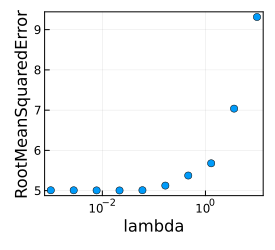

In [271]:
Plots.plot(tuned_lasso_machine)

Unfortunately this doesn't work with `Makie` but we can take the convenience. 

`report` also gets us some useful information too:

In [272]:
report(tuned_lasso_machine)

(best_model = LassoRegressor(lambda = 0.02154434690031884, …),
 best_history_entry = (model = LassoRegressor(lambda = 0.02154434690031884, …),
                       measure = [RootMeanSquaredError()],
                       measurement = [5.00501639997187],
                       per_fold = [[5.195550421954174, 5.594465814013773, 4.114753673922431, 4.854588100919187, 5.14401890179805]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJLinearModels.LassoRegressor, Vector{RootMeanSquaredError}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = LassoRegressor(lambda = 0.02154434690031884, …), measure = [RootMeanSquaredError()], measurement = [5.00501639997187], per_fold = [[5.195550421954174, 5.594465814013773, 4.114753673922431, 4.854588100919187, 5.14401890179805]]), (model = LassoRegressor(lambda = 0.007742636826811269, …), measure = [RootMeanSquaredError()], measurement = [5.00631391933102], per_fold = [[5.173141601266498, 5.583597171707226, 4.117843599

Since this is a `NamedTuple` we can get specific things out, like the RMSE for each value of $\lambda$ in our search:

In [273]:
report(tuned_lasso_machine).plotting.measurements

10-element Vector{Float64}:
 5.00501639997187
 5.00631391933102
 5.67902723720285
 9.313715174414954
 7.037660609843977
 5.375361457189756
 5.125607287752084
 5.0109484736056835
 5.009033242868468
 5.009675758229785

And we can get the best history entry RMSE:

In [274]:
report(tuned_lasso_machine).best_history_entry

(model = LassoRegressor(lambda = 0.02154434690031884, …),
 measure = [RootMeanSquaredError()],
 measurement = [5.00501639997187],
 per_fold = [[5.195550421954174, 5.594465814013773, 4.114753673922431, 4.854588100919187, 5.14401890179805]],)

We see there under `measurement` the measured RMSE in the grid search at that `lambda` value.

In [277]:
y_pred = predict(tuned_lasso_machine, X_test_standardized)
best_lasso_rmse = rms(y_pred, y_test)
println("Best Lasso RMSE: $best_lasso_rmse")

Best Lasso RMSE: 4.6343333341600985


So here we see we got a minor improvement in test RMSE compared to linear regression but still not as good as the default random forest.

# Wrapping up the steps as a `Pipeline`

So in the above lasso model, we applied the following steps to the `boston` dataset:

1. Updated datatypes to be `Continuous` type
2. Applied a `Standardizer` to the features
3. Used a `Grid` and `TunedModel` to find an optimal parameter value of $\lambda$
4. Calculate the test RMSE with the best model from step 3

Reference:
* [Composing Models](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/)

Let's recap the steps in a single code cell:

In [287]:
# Load in boston housing market data
boston = load_boston() |> DataFrame

# Train Test Split with `partition`
train, test = partition(boston, 0.8, rng=42);

# As before, unpack to horizontally split into y and X
y_train, X_train = unpack(train, ==(:MedV))
y_test, X_test = unpack(test, ==(:MedV));

# 1. Coerce datatypes
X_train = coerce(X_train, :Chas=>Continuous)
X_test = coerce(X_test, :Chas=>Continuous)

# 2. Standardize
Standardizer = @load Standardizer pkg=MLJModels verbosity=0
# Just like the other models, we instantiate it and bind data to it with a machine
standardizer = Standardizer()
standardizer_machine = machine(standardizer, X_train) |> fit!

# And transform
X_train_standardized = MLJ.transform(standardizer_machine, X_train)
X_test_standardized = MLJ.transform(standardizer_machine, X_test)

# 3. Load and Tune Model
# Load in our model and instantiate it
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels verbosity=0
lasso = LassoRegressor()

parameter_range = range(lasso, :lambda, lower=0.001, upper=10.0, scale=:log)
tuned_lasso = TunedModel(lasso, 
                         resampling=CV(nfolds=5, rng=42), 
                         tuning=Grid(resolution=10), # Search over 10 values between 'lower' and 'upper' in `parameter_range`
                         range=parameter_range, 
                         measure=rms)

# As before we then need to take this model and bind it to data as a machine,
# note that we don't pipe it with `|>` into fit! this time.
tuned_lasso_machine = machine(tuned_lasso, X_train_standardized, y_train)
# Here we call fit! separately so we can set verbosity to 0
fit!(tuned_lasso_machine, verbosity=0)

# 4. Predict
y_pred = predict(tuned_lasso_machine, X_test_standardized)
best_lasso_rmse = rms(y_pred, y_test)
println("Best Lasso RMSE: $best_lasso_rmse")

Best Lasso RMSE: 4.6343333341600985


### Method 1: Using the julia base pipe `|>`

In [324]:
# Load in boston housing market data
boston = load_boston() |> DataFrame

# Train Test Split with `partition`
train, test = partition(boston, 0.8, rng=42);

# As before, unpack to horizontally split into y and X
y_train, X_train = unpack(train, ==(:MedV))
y_test, X_test = unpack(test, ==(:MedV));

# Specify the tuned_lasso model
parameter_range = range(lasso, :lambda, lower=0.001, upper=10.0, scale=:log)
tuned_lasso = TunedModel(lasso, 
                         resampling=CV(nfolds=5, rng=42), 
                         tuning=Grid(resolution=10), # Search over 10 values between 'lower' and 'upper' in `parameter_range`
                         range=parameter_range, 
                         measure=rms)

# Return a `DeterministicPipeline` model
pipe = (X_train -> coerce(X_train, :Chas=>Continuous)) |> Standardizer() |> tuned_lasso

DeterministicPipeline(
  f = var"#17#18"(), 
  standardizer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  deterministic_tuned_model = DeterministicTunedModel(
        model = LassoRegressor(lambda = 1.0, …), 
        tuning = Grid(goal = nothing, …), 
        resampling = CV(nfolds = 5, …), 
        measure = RootMeanSquaredError(), 
        weights = nothing, 
        class_weights = nothing, 
        operation = nothing, 
        range = NumericRange(0.001 ≤ lambda ≤ 10.0; origin=5.0005, unit=4.9995; on log scale), 
        selection_heuristic = MLJTuning.NaiveSelection(nothing), 
        train_best = true, 
        repeats = 1, 
        n = nothing, 
        acceleration = CPU1{Nothing}(nothing), 
        acceleration_resampling = CPU1{Nothing}(nothing), 
        check_measure = true, 
        cache = true), 
  cache = true)

A pipeline is just another model, so we can bind it to a `machine` and `evaluate`, `predict`, etc. 

Here we bind a `machine` and `predict` on the `X_test` data to get predictions and calculate the RMSE on the test set:

In [333]:
pipe_machine = machine(pipe, X_train, y_train)
fit!(pipe_machine, verbosity=0)

y_pred_pipeline = predict(pipe_machine, X_test)
rms(y_pred_pipeline, y_test)

4.6343333341600985

## Method 2: Using a `Pipeline()` 

For clarity, it may be helpful to use a `Pipeline` method instead in which we create the model with `Pipeline`:

In [334]:
# Using a `Pipeline` function instead of using the base `|>` pipes
pipe = Pipeline(
    transformer = (X_train -> coerce(X_train, :Chas=>Continuous)),
    standardizer = Standardizer(),
    tuner = tuned_lasso
);

This creates the same pipeline as before, and we can get our predictions out from a new `machine` again:

In [335]:
pipe_machine = machine(pipe, X_train, y_train)
fit!(pipe_machine, verbosity=0)

y_pred_pipeline = predict(pipe_machine, X_test)
rms(y_pred_pipeline, y_test)

4.6343333341600985